In [1]:
from os import listdir
from os.path import join

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm, figure
from IPython.display import set_matplotlib_formats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
set_matplotlib_formats('svg')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

from parse_midi import Midi
from parse_midi import MessageType
import parse_midi

import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style("darkgrid")

In [2]:
midi_dir = './midi_files'
midi_paths = [join(midi_dir, x) for x in listdir(midi_dir)]
fp = midi_paths[1]
fp

'./midi_files/mz_333_2.mid'

In [3]:
m = Midi.from_file(fp)
notes_data = pd.DataFrame(m.note_times())
notes_data.head()

,start,end,midi,vel
0,0.00096,0.46176,67,59
1,0.00096,0.46176,70,59
2,0.46080,0.71040,68,55
3,0.46080,0.71040,65,55
4,0.00096,0.92256,51,51


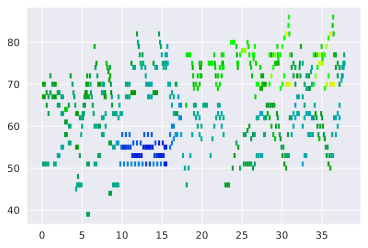

In [4]:

def plot_piano_roll(timed_notes, axis, color=None):
    velocity_map = cm.nipy_spectral(np.linspace(0,1,127))
    min_width = 0.25

    for _, note in timed_notes.iterrows():
        width = max(min_width, note['end'] - note['start'])
        tr = (note['start'], note['start'] + width)
        midi_note = note['midi']
        vel = int(note['vel'])
        c = color if color is not None else velocity_map[vel]
        axis.plot(tr, [midi_note, midi_note], lw=5, solid_capstyle='butt', color=c)


fig = plt.figure()
ax = fig.add_subplot()
plot_piano_roll(notes_data[:500], ax)
# print(x)

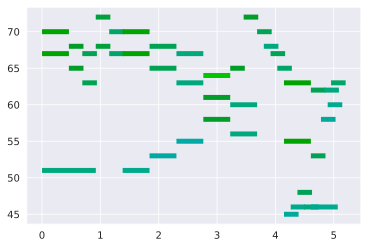

In [5]:
def filter_timerange(timed_notes, start, end):
    # returns all notes that occurr during start-end
    return timed_notes[(timed_notes.end > start) & (timed_notes.start < end)]

ax = plt.subplot()
plot_piano_roll(filter_timerange(notes_data, 0, 5), ax)

In [6]:
unique_onsets = pd.Series(notes_data['start'].unique()).sort_values()
onset_deltas = (unique_onsets - unique_onsets.shift())[1:]
onset_deltas = onset_deltas[onset_deltas > 0.000001]

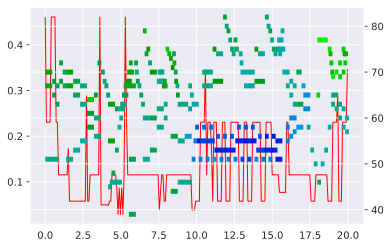

In [7]:
fig = plt.figure()
ax = fig.add_subplot()

d = notes_data[:250]

end_time = max(d['end'])
xs = [end_time * x / 250 for x in range(250)]
ax.plot(xs, onset_deltas[:250], color='r', lw=1)
ax2 = ax.twinx()
plot_piano_roll(d, ax2)


In [8]:
slice_duration = 0
p = 0
while p < 0.05:
    count = 0
    for t in onset_deltas:
        if slice_duration >= t:
            count += 1
    p = count / len(onset_deltas)
    slice_duration += 0.00001

slice_duration


0.05761000000000697

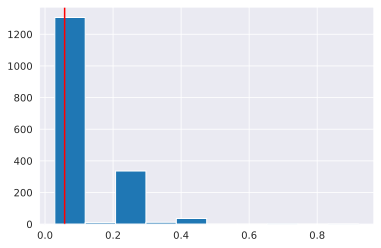

In [9]:
ax = onset_deltas.hist()
ax.axvline(x=slice_duration, color='red')

In [10]:

notes_duration = max(notes_data['end']) - min(notes_data['start'])
num_slices = int(notes_duration // slice_duration + 1)

slice_to_id = []
for i in range(num_slices):
    slice_to_id.append({
        'start': i * slice_duration,
        'end': (i + 1) * slice_duration,
        'id': i
    })

slice_to_id = pd.DataFrame(slice_to_id)
slice_to_id[(slice_to_id.end > 10) & (slice_to_id.start < 11)]

word_memberships = {}
for _, note in notes_data.iterrows():
    slices = filter_timerange(slice_to_id, note['start'], note['end'])
    for slice_id in slices['id']:
        if slice_id in word_memberships:
            word_memberships[slice_id].append(note)
        else:
            word_memberships[slice_id] = [note]
    
word_memberships[0]

[start     0.00096
 end       0.46176
 midi     67.00000
 vel      59.00000
 Name: 0, dtype: float64, start     0.00096
 end       0.46176
 midi     70.00000
 vel      59.00000
 Name: 1, dtype: float64, start     0.00096
 end       0.92256
 midi     51.00000
 vel      51.00000
 Name: 4, dtype: float64]

In [11]:
words = []
for slice_id in word_memberships.keys():
    words.append(pd.DataFrame(word_memberships[slice_id]))
    
words[0]

,start,end,midi,vel
0,0.00096,0.46176,67.0,59.0
1,0.00096,0.46176,70.0,59.0
4,0.00096,0.92256,51.0,51.0


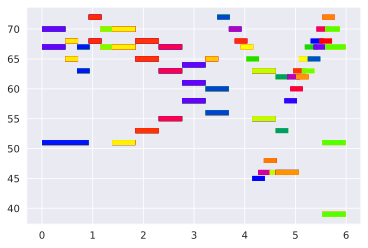

In [12]:
# Draw slices
import numpy as np

fig = plt.figure()
ax = fig.add_subplot()

cmap = cm.prism(np.linspace(0,1,100))
for i, word in enumerate(words[:100]):
    plot_piano_roll(word, ax, color=cmap[i])


> In order to study the extend to which word2vec can model musical context, polyphonic musical
pieces are represented with as little injected musical knowledge as possible. Each piece is simply
segmented into equal-length, non-overlapping slices. The duration of these slices is calculated
for each piece based on the distribution of time between note onsets. The smallest amount of
time between consecutive onsets that occurs in more than 5% of all cases is selected as the
slice-size. The slices capture all pitches that sound in a slice: those that have their onset in the
slice, and those that are played and held over the slice. The slicing process does not depend
on musical concepts such as beat or time signature; instead, it is completely data-driven. Our
vocabulary of words, will thus consist of a collection of musical slices.
In addition, we do not label pitches as chords...

In [13]:
len(words)

3894

In [14]:
compressed = []
for word in words:
    w = frozenset({'n': frozenset(word['midi']), 'v': word['vel'].mean().round(-1)}.items())
    compressed.append(w)
#     break
# word_notes = 
# word_vels = 
# w = [word_notes, word_vels]
# w
len(compressed)
# compressed

3894

In [25]:
import json
sentences = json.loads(open('sentences.json', 'r').read())

sentences['./midi_files/mz_545_3.mid'][0]

[{'end': 0.5184, 'midi': 79.0, 'start': 0.4608, 'vel': 50.0},
 {'end': 0.5184, 'midi': 76.0, 'start': 0.4608, 'vel': 42.0}]

In [47]:
all_words = []
for _, sent in sentences.items():
    all_words += sent
    

immut_words = []
for word in all_words:
    notes = [int(x['midi']) for x in word]
#     avg_vel = int(sum([x['vel'] for x in word]) / len(word))
    w_rep = frozenset(notes)
    immut_words.append(w_rep)

len(immut_words)

113016

In [45]:
unique_words = set(immut_words)
unique_words.pop()

frozenset({67, 69, 73, 78})